In [55]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
tweets = pd.read_csv('tweets.csv', encoding='iso-8859-1')

In [57]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [58]:
# Renaming table column names
tweets.rename(columns={'0': 'tweet_text',
                       'emotion_in_tweet_is_directed_at': 'brand',
                       'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}
                       , inplace=True)

<ipython-input-59-65094b23f634>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotion.index, rotation=-35, ha='left');


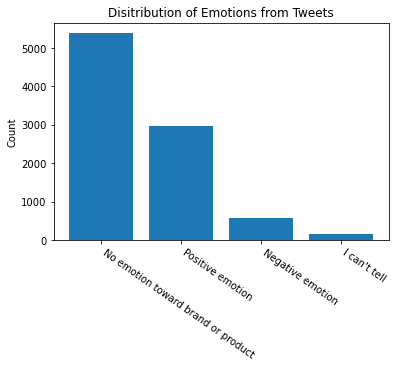

In [59]:
# Finding the distribution of emotion for tweets
emotion = tweets['emotion'].value_counts()

fig, ax = plt.subplots()
ax.bar(x=emotion.index, height=emotion)

ax.set_title('Disitribution of Emotions from Tweets');
ax.set_xticklabels(emotion.index, rotation=-35, ha='left');
ax.set_ylabel('Count');

<ipython-input-60-533414974702>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotion.index, rotation=-35, ha='left');


Text(0.5, 1.0, 'Disitrubtion of Products from Tweets')

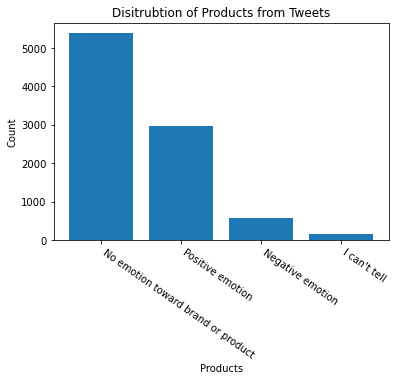

In [60]:
emotion = tweets['emotion'].value_counts()

fig, ax = plt.subplots()

ax.bar(x=emotion.index, height=emotion);
ax.set_xticklabels(emotion.index, rotation=-35, ha='left');
ax.set_xlabel('Products')
ax.set_ylabel('Count')
ax.set_title('Disitrubtion of Products from Tweets')

In [61]:
chatgpt = pd.read_csv('chatgpt_tweets.csv') # Negative tweets generated from ChatGPT

unique_gpt_tweets = pd.DataFrame(chatgpt['Tweets'].unique()) # Remove duplicate tweets generated from ChatGPT

# Create new columns with 'Apple' and 'Negative emotion'ArithmeticError as the values
unique_gpt_tweets['brand'] = 'Apple'
unique_gpt_tweets['emotion'] = 'Negative'

unique_gpt_tweets.rename(columns={0: 'tweet_text'}, inplace=True)

In [62]:
unique_gpt_tweets.head()

,tweet_text,brand,emotion
0,Apple's desperation for attention is evident w...,Apple,Negative
1,Barry Diller's thoughts on iPad-only content s...,Apple,Negative
2,Japan had mobile apps long before Apple's app ...,Apple,Negative
3,"Seriously, an Apple pop-up over a Gold's Gym? ...",Apple,Negative
4,The #SXSW stream is filled with inane iPad 2 t...,Apple,Negative


In [63]:
apple_tweets = tweets.copy()

apple_products = {'iPad': 'Apple',
                  'Apple': 'Apple',
                  'iPad or iPhone App': 'Apple',
                  'iPhone': 'Apple',
                  'Other Apple product or service': 'Apple'}

# Replace all apple products with the word 'Apple'
apple_tweets['brand'] = apple_tweets['brand'].map(apple_products)

# Get tweets that are only about Apple
apple_tweets = apple_tweets.loc[(apple_tweets['brand'] == 'Apple') & ((apple_tweets['emotion'] == 'Positive emotion') | (apple_tweets['emotion'] == 'Negative emotion'))] 

emotion = {'Negative emotion': 'Negative', 'Positive emotion': 'Positive'}
apple_tweets['emotion'] = apple_tweets['emotion'].map(emotion)

# Concat human-made Apple tweets with ChatGPT generated tweets
apple_tweets_with_gpt = pd.concat([apple_tweets, unique_gpt_tweets])

numeric_emotion = {'Negative':0, 'Positive': 1}
apple_tweets_with_gpt['emotion'] = apple_tweets_with_gpt['emotion'].map(numeric_emotion)

apple_tweets_with_gpt['emotion'].value_counts()

1    1949
0     879
Name: emotion, dtype: int64

In [64]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Tokenizer
pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(pattern)

# Removing stop words
stopwords_list = stopwords.words('english')
stopwords_list.extend(['app', 'apple', 'sxsw', 'sxswi'])

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

# Lowercase text
apple_tweets_with_gpt['tweet_text'] = apple_tweets_with_gpt['tweet_text'].str.lower()
# Tokenize text
apple_tweets_with_gpt['text_tokenized'] = apple_tweets_with_gpt['tweet_text'].apply(tokenizer.tokenize)
# Remove stop words from text
apple_tweets_with_gpt['text_tokenized'] = apple_tweets_with_gpt['text_tokenized'].apply(remove_stopwords)

In [65]:
apple_tweets_with_gpt['emotion'].value_counts(normalize=True)

1    0.68918
0    0.31082
Name: emotion, dtype: float64

In [66]:
from sklearn.model_selection import train_test_split

X = apple_tweets_with_gpt['tweet_text']
y = apple_tweets_with_gpt['emotion']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train

4684    dan neumann just announced the launch of organ...
170     buying an ipad for someone at #sxsw launch day...
8430    @mention the geeks need somewhere downtown to ...
265     everyone with an ipad looks like they're stuck...
4572    the internet blurs, {link} the ipad fades, {li...
                              ...                        
7189    #sxsw #hootsuite #chilltab #tablet stand rocks...
6003    rt @mention hey #sxsw- ers rt @mention rt @men...
5466    rt @mention apple set to open popup shop in co...
3041    ipad 2 goes on sale at 3 pm at #sxsw - i'm loo...
3554    @mention i know this is a premature tweet, but...
Name: tweet_text, Length: 2121, dtype: object

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(document):
    tokens = tokenizer.tokenize(document)
    return tokens

tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=stopwords_list,
    tokenizer=tokenize)

X_train_vectorized = tfidf.fit_transform(X_train)

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())


,amp,apps,austin,day,get,ipad,ipad2,iphone,launch,like,line,link,mention,new,one,pop,quot,rt,store,via
0,0.0,0.0,0.000000,0.000000,0.000000,0.372848,0.0,0.00000,0.927892,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
1,0.0,0.0,0.000000,0.683633,0.000000,0.272114,0.0,0.00000,0.677200,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
2,0.0,0.0,0.000000,0.000000,0.643616,0.283199,0.0,0.00000,0.000000,0.000000,0.645121,0.000000,0.298959,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
3,0.0,0.0,0.000000,0.000000,0.000000,0.401960,0.0,0.00000,0.000000,0.915657,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
4,0.0,0.0,0.000000,0.000000,0.000000,0.348693,0.0,0.00000,0.000000,0.000000,0.000000,0.861926,0.368098,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,0.0,0.0,0.000000,0.000000,0.000000,0.524003,0.0,0.00000,0.000000,0.000000,0.000000,0.647635,0.553164,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
2117,0.0,0.0,0.282976,0.365148,0.330318,0.000000,0.0,0.19965,0.000000,0.000000,0.000000,0.179636,0.460298,0.0,0.0,0.000000,0.0,0.627278,0.00000,0.000000
2118,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.333124,0.569061,0.0,0.0,0.000000,0.0,0.387748,0.00000,0.644089
2119,0.0,0.0,0.000000,0.000000,0.000000,0.687712,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.725984,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000


In [78]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.8264969354078265

In [81]:
from sklearn.metrics import recall_score

X_test_vectorized = tfidf.transform(X_test)
y_pred = rf.predict(X_test_vectorized)

recall_score(y_test, y_pred)


0.8090349075975359